# Predicting Bike Rentals

The Washington, D.C. bike share program collects detailed data on the number of bicycles people rent by the hour and day. We'll use some public data from this bike share program to create and test machine learning models to predict the total number of bike rentals in a given hour.

The dataset for this project originates from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). It contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

## Introduction to the Data Set

The file `bike_rental_hour.csv` contains detailed data on the number of bicycles people rent by the hour and day. There are 17380 rows, each representing the number of bike rentals for a single hour of a single day.

Here are the descriptions for the relevant columns:
 - instant - A unique sequential ID number for each row
 - dteday - The date of the rentals
 - season - The season in which the rentals occurred
 - yr - The year the rentals occurred
 - mnth - The month the rentals occurred
 - hr - The hour the rentals occurred
 - holiday - Whether or not the day was a holiday
 - weekday - The day of the week (as a number, 0 to 7)
 - workingday - Whether or not the day was a working day
 - weathersit - The weather (as a categorical variable)
 - temp - The temperature, on a 0-1 scale
 - atemp - The adjusted temperature
 - hum - The humidity, on a 0-1 scale
 - windspeed - The wind speed, on a 0-1 scale
 - casual - The number of casual riders (people who hadn't previously signed with the bike sharing program)
 - registered - The number of registered riders (people who had already signed up)
 - cnt - The total number of bike rentals (casual + registered)
 
We will be predicting the number of bikes rented in a given hour (`cnt`), using the other features in the data set (except registered and casual - these sum to `cnt`). To do this we will train several different machine learning models and evaluate their performance, starting with a linear regression model.

In [9]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals = bike_rentals.drop(['registered','casual'],axis=1)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


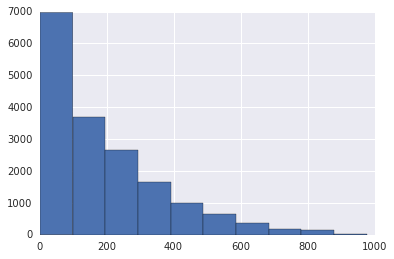

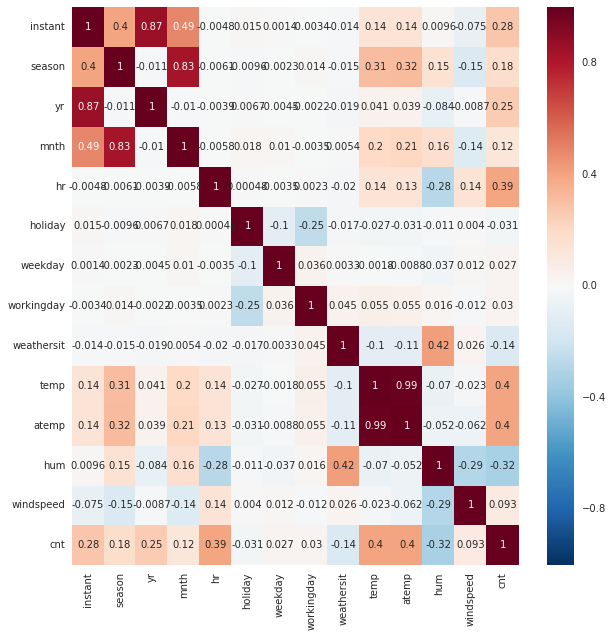

In [10]:
bike_rentals['cnt'].hist()
plt.show()
plt.figure(figsize=(10,10))
corr_mat = bike_rentals.corr()
sns.heatmap(corr_mat,annot=True)

No column has a correlation with cnt above .4, a threshold we've used to exclude features from previous linear regressions, suggesting we will need a more perceptive machine learning model than linear regression. However, we'll train and test a linear regression model first to get a baseline.

## Calculating Features

The `hr` column contains an hour value between `0` and `23`, but hours are related to each other. Lets group these into `morning`, `afternoon`, `evening`, and `night`.

In [11]:
# assign_label uses the following numeric lables
# 1 - morning
# 2 - afternoon
# 3 - evening
# 4 - night
def assign_label(v):
    if v < 6:
        return 1
    if v < 12:
        return 2
    if v < 18:
        return 3
    return 4
        
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.drop('hr',axis=1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
0,1,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.81,0.0000,16,1
1,2,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,1
2,3,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,32,1
3,4,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,13,1
4,5,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,1,1
5,6,2011-01-01,1,0,1,0,6,0,2,0.24,0.2576,0.75,0.0896,1,1
6,7,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,2,2
7,8,2011-01-01,1,0,1,0,6,0,1,0.20,0.2576,0.86,0.0000,3,2
8,9,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,8,2
9,10,2011-01-01,1,0,1,0,6,0,1,0.32,0.3485,0.76,0.0000,14,2


## Splitting the Data Into Train and Test Sets

In [12]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Error Metric

We'll use root meat squared error (RMSE) for our error metric as it works well with continuous numeric data.

## Applying Linear Regression

As discussed before, a linear regression model won't do great on this data, but we'll train and test one as a baseline.

### Feature Selection

#### Multicollinearity

Looking at the correlation heatmap above, several features are highly correlated with each other. We'll want to remove some features so that none are pairwise highly correlated.

   - `mnth` and `season` - We'll get rid of `mnth`. Season captures the relation between months better and is more highly correlated with `cnt`
   - `temp` and `atemp` - We'll get rid of `temp`. Both metrics contain basically the same information, and `atemp` is trying harder to get at the human experience.
   
   
#### Other unnecessary columns

We'll also drop a few other columns.

   - `instant` -  This is just a row label.
   - `dteday` - It is not numeric and the date information is captured in other columns.
   - `holiday`,`weekday`,`workingday` - These have very little correlation with `cnt` so will not be useful for our regression.

In [50]:
features = train.columns
#drop_cols = ['mnth','temp','instant','dteday','holiday','weekday','workingday']
drop_cols = ['dteday']
features = features.drop(drop_cols)
features = features.drop('cnt') # this is the target column

### Train and test

In [51]:
lr = LinearRegression()
lr.fit(train[features],train['cnt'])
predictions = lr.predict(test[features])
rmse = np.sqrt(mean_squared_error(test['cnt'],predictions))
train_rmse = np.sqrt(mean_squared_error(train['cnt'],lr.predict(train[features])))

print("Root Mean Squared Error:", rmse)
print("Train RMSE:", train_rmse)
print("\nMean:", bike_rentals['cnt'].mean())

Root Mean Squared Error: 138.19671707502698
Train RMSE: 139.77153621486434

Mean: 189.46308763450142


This is probably decent for a linear regression model, but the error seems quite high as our mean daily bike rides is about 190 and the error on this regression model is 140 which is 75% of the mean.

Next we will try some other machine learning models to see if they fare better.

## Applying Decision Trees

### Feature Selection

We'll add back in `holiday`,`weekday`, and `workingday` as features. These were not very correlated with `cnt` making them not useful for linear regression. However, decision tress are capable of capturing non-linear interactions which these features might be a part of.

In [49]:
features.tolist().append(['holiday','weekday','workingday'])

### Train and Test

We expect the Decision Tree model to overfit if we don't limit the maximum depth the tree can attain. So we will play around with the tree parameters to see how it effects the error.

First we'll create a function so we can repeatedly train and test decision tree models easily.

In [52]:
def dt_train_test(md=None,msl=1,mss=2,mln=None):
    dt = DecisionTreeRegressor(max_depth = md,
                                min_samples_leaf = msl,
                                min_samples_split = mss,
                                max_leaf_nodes = mln)
    dt.fit(train[features],train['cnt'])
    dt_predictions = dt.predict(test[features])
    dt_rmse = np.sqrt(mean_squared_error(test['cnt'],dt_predictions))
    dt_train_rmse = np.sqrt(
        mean_squared_error(train['cnt'],dt.predict(train[features])))
        
    return dt_train_rmse, dt_rmse

error = dt_train_test()
print('Train RMSE:', error[0])
print('Test RMSE', error[1])

Train RMSE: 0.0
Test RMSE 58.640772664095394


While the error is much lower for this model, we can see by the difference between the training and testing error that this model is extremely overfitting on the training data. This model will not work well on new data.

Let's play around with some model parameters to limit tree complexity.

### Hyperparameter Optimization

There are four parameters that can be used in `DecisionTreeClassifier` to control the depth and overfitting of the tree:

- `max_depth`
- `min_samples_leaf`
- `min_samples split`
- `max_leaf_nodes`

Let's look at how train and test error vary with these parameters

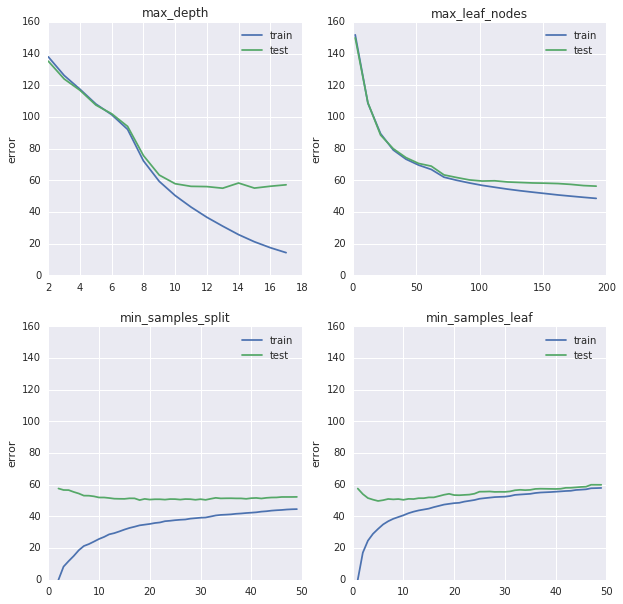

In [53]:
# Function to graph train vs test error for different values on a single
# parameter for our decision tree.
def graph_param_errors(param,ax,values=np.arange(2,18)):    
    train_errors = []
    test_errors = []
    for value in values:
        if param == 'max_depth':
            errors = dt_train_test(md=value)
        elif param == 'min_samples_leaf':
            errors = dt_train_test(msl=value)
        elif param == 'min_samples_split':
            errors = dt_train_test(mss=value)
        elif param == 'max_leaf_nodes':
            errors = dt_train_test(mln=value)
        train_errors.append(errors[0])
        test_errors.append(errors[1])
    ax.plot(values,train_errors,label='train')
    ax.plot(values,test_errors,label='test')
    ax.set_title(param)
    ax.set_ylim(0,160)
    ax.set_ylabel('error')
    ax.legend()

fig, axes = plt.subplots(2,2,figsize=(10,10))


graph_param_errors('max_depth',ax=axes[0,0])
graph_param_errors('min_samples_leaf',ax=axes[1,1],values=np.arange(1,50))
graph_param_errors('min_samples_split',ax=axes[1,0],values=np.arange(2,50))
graph_param_errors('max_leaf_nodes',ax=axes[0,1],values=np.arange(2,202,10))
plt.show()

The `max_depth` graph is a great example of the typical trend between train error and test error as a model gets more complex, which in this case means a deeper tree. As a model goes from simple to mildly complex, the train error and test error both go down, but when a model gets past a certain complexity threshold the two errors diverge, with the train error going down and the test error going up. This indicates overfitting, as the model is learning the train set too well making it less useful on data outside of the train set.

Note: For both "max" parameters (top two graphs) complexity increases as you go right on the x-axis, while for the "min" parameters (bottom two graphs) complexity increases as you you go left on the x-axis.

The other three graphs also show this pattern. For a final decision tree model we will pick two of these parameters and try to combine each at it's sweet spot. We'll use `max_depth` and `min_samples_leaf`.

In [68]:
error = dt_train_test(md=9,msl=20)
print('Train RMSE:', error[0])
print('Test RMSE', error[1])

Train RMSE: 61.47988649837659
Test RMSE 63.99215424133928


With these parameters, our train and test errors are very close, indicating overfitting is now less of a problem. An RMSE of 64 indicates our decision tree model does a lot better on this data than the linear regression model that had an RMSE of 140.

## Applying Random Forests

We expect a Random Forest model, which is an ensemble of the Decision Trees we just looked at, to be much more resistant to overfitting. Let's take a look.

In [69]:
def rf_train_test(n=20,md=None,msl=1,mss=2,mln=None):
    rf = RandomForestRegressor(n_estimators = n,
                                  max_depth=md)
    rf.fit(train[features],train['cnt'])
    rf_predictions = rf.predict(test[features])
    rf_rmse = np.sqrt(mean_squared_error(test['cnt'],rf_predictions))
    rf_train_rmse = np.sqrt(
        mean_squared_error(train['cnt'],rf.predict(train[features])))
        
    return rf_train_rmse, rf_rmse

error = rf_train_test()
print('Train RMSE:', error[0])
print('Test RMSE', error[1])

Train RMSE: 16.63267540099155
Test RMSE 41.67844884816316


The initial errors for an unrestricted model show less overfitting than our initial decision tree model, but there is still a bit of overfitting. Let's use some of the decision tree parameters we found before to limit tree depth and also see how varying the number of trees in our forest (n_estimators) changes the accuracy of the random forest model.

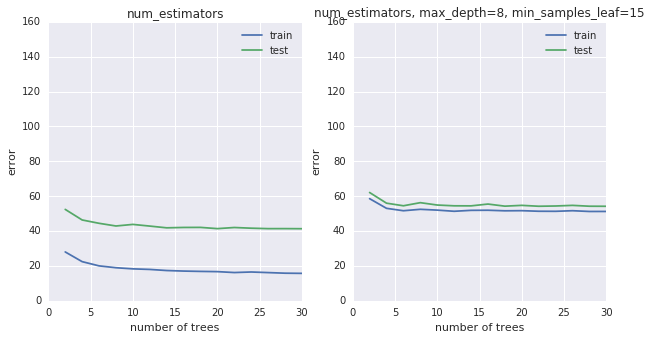

In [70]:
# Function to graph train vs test error for different values on a single
# parameter for our decision tree.
def rf_graph_param_errors(param,ax,values=np.arange(2,31,2)):    
    train_errors = []
    test_errors = []
    for value in values:
        if param == 'num_estimators':
            errors = rf_train_test(n=value)
        if param == 'num_estimators, max_depth=9, min_samples_leaf=20':
            errors = rf_train_test(n=value,md=9,msl=20)
        train_errors.append(errors[0])
        test_errors.append(errors[1])
    ax.plot(values,train_errors,label='train')
    ax.plot(values,test_errors,label='test')
    ax.set_title(param)
    ax.set_ylim(0,160)
    ax.set_ylabel('error')
    ax.set_xlabel('number of trees')
    ax.legend()

fig, axes = plt.subplots(1,2,figsize=(10,5))

rf_graph_param_errors('num_estimators',ax=axes[0])
rf_graph_param_errors('num_estimators, max_depth=9, min_samples_leaf=20',ax=axes[1])

plt.show()

The left plot shows train and test error for random forest models using variable number of unrestricted trees. We can see here that increasing the number of trees in the forest doesn't fix our overfitting problem.

The right plot shows error for random forest models using trees that are limited in the same way we limited our decision tree model from earlier. Here our overfitting problem is greatly improved.

Further, our forests don't appear to benefit from more trees past about ten or fifteen.

Let's make our final model now as a random forest with fifteen depth-limited trees.

In [20]:
final_model = RandomForestRegressor(n_estimators=15,
                                    max_depth=8,
                                    min_samples_leaf=15)
final_model.fit(train[features],train['cnt'])
fm_predictions = final_model.predict(test[features])
fm_rmse = np.sqrt(mean_squared_error(test['cnt'],fm_predictions))
fm_train_rmse = np.sqrt(
        mean_squared_error(train['cnt'],final_model.predict(train[features])))
print("Train RMSE:", fm_train_rmse)
print("Test RMSE:", fm_rmse)

Train RMSE: 88.79588526018252
Test RMSE: 89.79357652722385


The random forest is not overfitting and we have our lowest error metrics yet.

## Conclusion

This project shows how we can use decision trees and random forests to improve upon a linear regression machine learning model. These models are capable of capturing non-linear relationships between features and our target variable allowing them to make more accurate preditions.

## Next Steps

Here are some potential next steps:
- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt.